In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')

model_dir = '2020_05_18_cfrmod_mono_notest'


In [2]:
loc_df = get_location_metadata(location_set_id=111, location_set_version_id=677)
loc_df = loc_df.loc[loc_df['path_to_top_parent'].str.startswith('102,')]
loc_df = loc_df.loc[loc_df['most_detailed'] == 1]
us_locs = loc_df['location_id'].to_list()

df = pd.read_csv(f'/ihme/covid-19/deaths/dev/{model_dir}/model_data.csv')
df['date'] = pd.to_datetime(df['Date'])
df = df.loc[df['location_id'].isin(us_locs)]
df = df.sort_values(['location_id', 'date'])
df['Cumulative predicted deaths'] = df['Predicted death rate'] * df['population']
df['Cumulative cases'] = df['Confirmed case rate'] * df['population']
df['Cumulative tests'] = df['Testing rate'] * df['population']

first_day = df['date'] == df.groupby('location_id')['date'].transform(min)
df['Daily predicted deaths'] = np.nan
df['Daily predicted deaths'][1:] = np.diff(df['Cumulative predicted deaths'])
df.loc[first_day, 'Daily predicted deaths'] = df['Cumulative predicted deaths']
df['Daily cases'] = np.nan
df['Daily cases'][1:] = np.diff(df['Cumulative cases'])
df.loc[first_day, 'Daily cases'] = df['Cumulative cases']
df['Daily tests'] = np.nan
df['Daily tests'][1:] = np.diff(df['Cumulative tests'])
df.loc[first_day, 'Daily tests'] = df['Cumulative tests']
df['Daily CFR'] = df['Daily predicted deaths'] / df['Daily cases']
df['Cumulative CFR'] = df['Cumulative predicted deaths'] / df['Cumulative cases']

df = df[['location_id', 'location_name', 'date', 'population', 
         'Cumulative CFR', 'Daily CFR',
         'Cumulative predicted deaths', 'Cumulative cases', 'Cumulative tests',
         'Daily predicted deaths', 'Daily cases', 'Daily tests']]

nat_df = df.copy()
nat_df['location_id'] = 102
nat_df['location_name'] = 'United States of America'
nat_df = (nat_df
          .groupby(['location_id', 'location_name', 'date'], as_index=False)
          ['population', 'Cumulative predicted deaths', 'Cumulative cases', 'Cumulative tests',
           'Daily predicted deaths', 'Daily cases', 'Daily tests']
          .sum())
nat_df['Daily CFR'] = nat_df['Daily predicted deaths'] / nat_df['Daily cases']
nat_df['Cumulative CFR'] = nat_df['Cumulative predicted deaths'] / nat_df['Cumulative cases']
df = nat_df.append(df)

loc_df = df[['location_id', 'location_name']].drop_duplicates()


In [3]:
with PdfPages(f'/ihme/covid-19/deaths/dev/{model_dir}/cfr_plots.pdf') as pdf:
    for location_id, location_name in zip(loc_df['location_id'], loc_df['location_name']):
        plot_df = df.loc[df['location_id'] == location_id].reset_index(drop=True)
        plot_df = plot_df.loc[plot_df['Cumulative predicted deaths'] > plot_df['Cumulative predicted deaths'].max() * 0.01]

        fig, ax = plt.subplots(2, 3, figsize=(22, 17))
        ax[0, 0].scatter(plot_df['date'], 
                    plot_df['Daily CFR'], s=100)
        ax[0, 0].set_xlabel('Date')
        ax[0, 0].set_ylabel('Daily CFR')
        ax[0, 1].scatter(plot_df['Daily tests'], 
                    plot_df['Daily CFR'], s=100)
        ax[0, 1].set_xlabel('Daily tests')
        ax[0, 1].set_ylabel('Daily CFR')
        ax[0, 2].scatter(plot_df['Daily cases'], 
                    plot_df['Daily predicted deaths'], s=100)
        ax[0, 2].set_xlabel('Daily cases')
        ax[0, 2].set_ylabel('Daily predicted deaths')

        ax[1, 0].scatter(plot_df['date'], 
                      plot_df['Cumulative CFR'], s=100)
        ax[1, 0].set_xlabel('Date')
        ax[1, 0].set_ylabel('Cumulative CFR')
        ax[1, 1].scatter(plot_df['Cumulative tests'], 
                      plot_df['Cumulative CFR'], s=100)
        ax[1, 1].set_xlabel('Cumulative tests')
        ax[1, 1].set_ylabel('Cumulative CFR')
        ax[1, 2].scatter(plot_df['Cumulative cases'], 
                      plot_df['Cumulative predicted deaths'], s=100)
        ax[1, 2].set_xlabel('Cumulative cases')
        ax[1, 2].set_ylabel('Cumulative predicted deaths')
        fig.suptitle(plot_df['location_name'].values[0], y=1.0025)
        fig.tight_layout()
        pdf.savefig()
        plt.close(fig)


Text(0, 0.5, 'CFR')

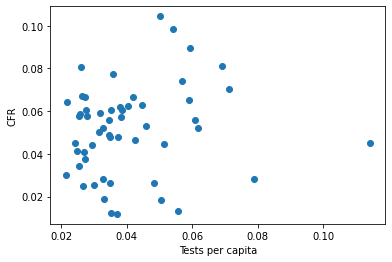

In [9]:
overall_df = df.loc[df['date'] == df.groupby('location_id')['date'].transform(max)].reset_index(drop=True)
overall_df['Testing rate'] = overall_df['Cumulative tests'] / overall_df['population']
plt.scatter(overall_df['Testing rate'], 
            overall_df['Cumulative CFR'])
plt.xlabel('Tests per capita')
plt.ylabel('CFR')


In [11]:
overall_df.sort_values('Testing rate')

,location_id,location_name,date,population,Cumulative predicted deaths,Cumulative cases,Cumulative tests,Daily predicted deaths,Daily cases,Daily tests,Daily CFR,Cumulative CFR,Testing rate
13,535,Idaho,2020-05-25,1.735119e+06,73.348385,2419.0,3.700834e+04,0.000000,0.0,779.309971,NaN,0.030322,0.021329
3,525,Arizona,2020-05-26,7.249680e+06,914.386039,14208.0,1.569386e+05,17.967448,263.0,5785.630392,0.068317,0.064357,0.021648
34,556,North Carolina,2020-05-26,1.059103e+07,869.045189,19207.0,2.555038e+05,20.101950,534.0,8637.792989,0.037644,0.045246,0.024125
47,569,Virginia,2020-05-26,8.695418e+06,1282.570969,31140.0,2.151772e+05,23.160669,752.0,6544.421403,0.030799,0.041187,0.024746
44,566,Texas,2020-05-26,2.841864e+07,1694.648305,49177.0,7.241232e+05,25.231613,781.0,28856.494430,0.032307,0.034460,0.025481
6,528,Colorado,2020-05-26,5.401063e+06,1285.072778,22202.0,1.376669e+05,11.263533,264.0,3600.053381,0.042665,0.057881,0.025489
29,551,Nevada,2020-05-26,3.215025e+06,414.914650,7061.0,8.243316e+04,6.849801,112.0,3172.238718,0.061159,0.058761,0.025640
39,561,Pennsylvania,2020-05-26,1.299486e+07,5377.654660,66669.0,3.369986e+05,100.056661,969.0,7459.183335,0.103258,0.080662,0.025933
36,558,Ohio,2020-05-26,1.157859e+07,1908.702639,28454.0,3.035485e+05,32.342243,531.0,11156.508416,0.060908,0.067080,0.026216
17,539,Kansas,2020-05-26,2.969706e+06,206.998612,8303.0,7.899231e+04,2.750557,350.0,3643.202307,0.007859,0.024931,0.026599
